In [1]:
# This notebook tests that stationarity of the sentiment variables
# and then makes stationary any variables that are not stationary.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [4]:
# Quick look at the first two lines of the TXT
with open('data/econ_and_sent_vars_consolidated.txt') as f:
    print(f.readline())
    next(f)
    print(f.readline())

month_date	tb	pi	ur	nyse	pce	ics	num_words	perc_pos	perc_neg	perc_uncert	perc_litig	perc_modal_wk	perc_modal_wod	perc_modal_str	perc_constrain	num_alphanum	num_digits	num_nums	avg_syll_word	avg_word_len	vocab	num_words_rev_weighted	perc_pos_rev_weighted	perc_neg_rev_weighted	perc_uncert_rev_weighted	perc_litig_rev_weighted	perc_modal_wk_rev_weighted	perc_modal_wod_rev_weighted	perc_modal_str_rev_weighted	perc_constrain_rev_weighted	num_alphanum_rev_weighted	num_digits_rev_weighted	num_nums_rev_weighted	avg_syll_word_rev_weighted	avg_word_len_rev_weighted	vocab_rev_weighted

2/1/11	0.13	12077.34136	9	8674.228596	10762.5176	77.5	8662.724138	2.025964984	0.991311045	0.929677755	0.06865454	0.421887611	0.697340185	0.626665545	0.094072965	43593.44828	599.3448276	221.3103448	1.521549135	4.681305418	1354.793103	9846.054438	2.055310798	0.93588036	0.887691462	0.064782495	0.390423476	0.556728544	0.729389353	0.115867806	50438.84659	828.7344123	312.4547135	1.555901554	4.800785644	1417.444823



In [5]:
# Set data types for features
dts = {"month_date": str
    , "perc_pos_rev_weighted": np.float64, "perc_neg_rev_weighted": np.float64
    , "perc_uncert_rev_weighted": np.float64, "perc_litig_rev_weighted": np.float64
    , "perc_modal_wk_rev_weighted": np.float64, "perc_modal_wod_rev_weighted": np.float64
    , "perc_modal_str_rev_weighted": np.float64, "perc_constrain_rev_weighted": np.float64}

In [6]:
# Set date feature to be parsed
parse_dates = ['month_date']

In [7]:
# Import data
data_raw = pd.read_csv("data/econ_and_sent_vars_consolidated.txt"
                   , sep="\t"
                   , skiprows=0
                   , dtype=dts
                    , usecols=[0,23,24,25,26,27,28,29,30]
                   , parse_dates=parse_dates)

In [8]:
# Rename a column
data_raw.rename(columns={'perc_modal_wod_rev_weighted': 'perc_modal_mod_rev_weighted'}, inplace=True)

In [9]:
# Check the dataframe
data_raw.head()

,month_date,perc_pos_rev_weighted,perc_neg_rev_weighted,perc_uncert_rev_weighted,perc_litig_rev_weighted,perc_modal_wk_rev_weighted,perc_modal_mod_rev_weighted,perc_modal_str_rev_weighted,perc_constrain_rev_weighted
0,2011-01-01,2.052988,0.931237,0.872381,0.062692,0.370912,0.511101,0.718103,0.116339
1,2011-02-01,2.055311,0.935880,0.887691,0.064782,0.390423,0.556729,0.729389,0.115868
2,2011-03-01,1.960705,0.979452,0.957425,0.073102,0.387479,0.560045,0.679831,0.142132
3,2011-04-01,1.938265,0.996468,0.923577,0.078601,0.333086,0.545895,0.664438,0.133149
4,2011-05-01,1.876116,0.981002,0.898622,0.096360,0.310098,0.529553,0.655445,0.123339


In [10]:
# Convert month column to regular column then set to index
data_raw['date'] = data_raw['month_date']
data_raw["month_date"] = data_raw["month_date"].dt.to_period('M')
data_raw = data_raw.set_index("month_date", drop=True)

In [11]:
# Copy to data
data = data_raw.copy()

In [12]:
# Create function to apply the Dickey-Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [13]:
# Run the Dickey-Fuller test on each sentiment feature
for column in data.iloc[:, 0:-1]:
    print ("\nTest Variable: {}\n".format(column))
    adf_test(data[column].dropna())


Test Variable: perc_pos_rev_weighted

Results of Dickey-Fuller Test:
Test Statistic                 -4.137713
p-value                         0.000838
#Lags Used                      0.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64

Test Variable: perc_neg_rev_weighted

Results of Dickey-Fuller Test:
Test Statistic                 -4.163463
p-value                         0.000759
#Lags Used                      0.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64

Test Variable: perc_uncert_rev_weighted

Results of Dickey-Fuller Test:
Test Statistic                -6.140022e+00
p-value                        8.013023e-08
#Lags Used                     0.000000e+00
Number of Observations Used    8.900000e+01
Critica

In [14]:
# Create function that displays two plots comparing stationary transformations
# Includes rolling mean

def two_plots(x, x_log):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
    fig.subplots_adjust(hspace=0.25)
    rm1 = x.rolling(window=12).mean()
    rm2 = x_log.rolling(window=12).mean()
    ax1.plot(data['date'], x)
    ax1.plot(data['date'], rm1)
    ax1.set_title(x.name)
    ax2.plot(data['date'], x_log)
    ax2.plot(data['date'], rm2)
    ax2.set_title(x_log.name)
    plt.show()

In [15]:
# Create function that displays three plots comparing transformations
# First two plots are same as above
# Third plot includes rolling mean and rolling standar deviation

def three_plots(x, x_log, x_log_diff):   
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))
    fig.subplots_adjust(hspace=0.5)
    rm1 = x.rolling(window=12).mean()
    rm2 = x_log.rolling(window=12).mean()
    rm3 = x_log_diff.rolling(window=12).mean()
    rsd3 = x_log_diff.rolling(window=12).std()
    ax1.plot(data['date'], x)
    ax1.plot(data['date'], rm1)
    ax1.set_title(x.name)
    ax2.plot(data['date'], x_log)
    ax2.plot(data['date'], rm2)
    ax2.set_title(x_log.name)
    ax3.plot(data['date'], x_log_diff)
    ax3.plot(data['date'], rm3)
    ax3.plot(data['date'], rsd3)
    ax3.set_title(x_log_diff.name)
    plt.show()

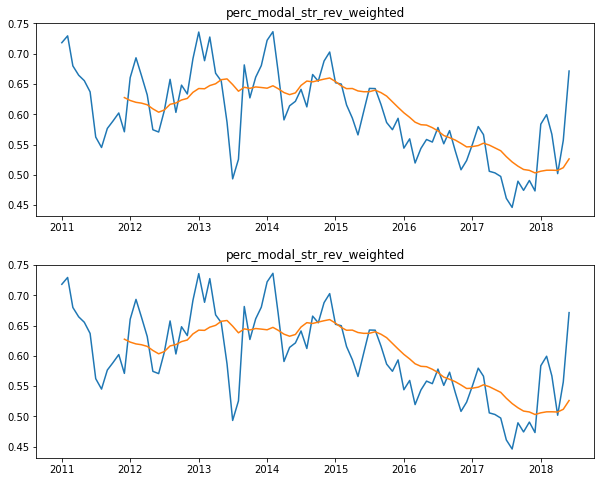

In [16]:
two_plots(data['perc_modal_str_rev_weighted'], data['perc_modal_str_rev_weighted'])

In [17]:
# Difference the feature order 2
data['perc_modal_str_rev_weighted_diff'] = data['perc_modal_str_rev_weighted'] - data['perc_modal_str_rev_weighted'].shift(1)

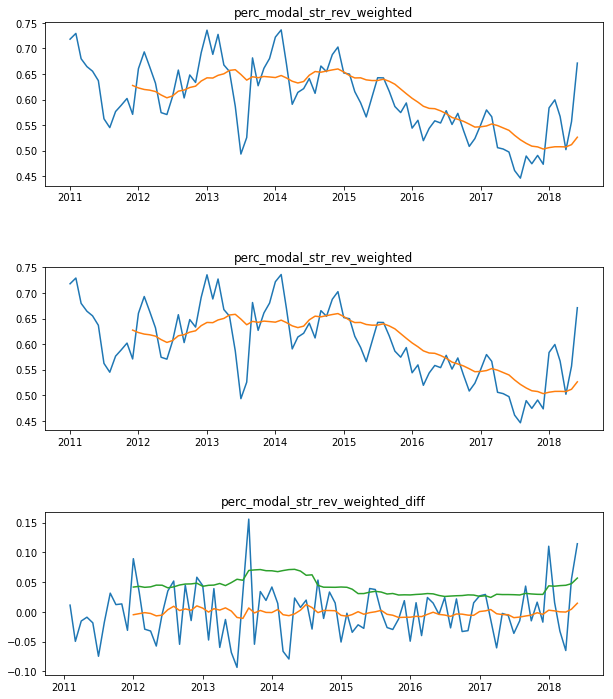

In [18]:
three_plots(data['perc_modal_str_rev_weighted'], data['perc_modal_str_rev_weighted'], data['perc_modal_str_rev_weighted_diff'])

In [19]:
# Set comlumns to test for stationarity after transformations
test_columns = ['perc_modal_str_rev_weighted_diff']

In [20]:
# Run the Dickey-Fuller test on the stationary features
for column in data[test_columns]:
    print ("\nTest Variable: {}\n".format(column))
    adf_test(data[column].dropna())


Test Variable: perc_modal_str_rev_weighted_diff

Results of Dickey-Fuller Test:
Test Statistic                -6.546560e+00
p-value                        9.068607e-09
#Lags Used                     6.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


In [21]:
# List all the features in the dataframe
print (data.columns)

Index(['perc_pos_rev_weighted', 'perc_neg_rev_weighted',
       'perc_uncert_rev_weighted', 'perc_litig_rev_weighted',
       'perc_modal_wk_rev_weighted', 'perc_modal_mod_rev_weighted',
       'perc_modal_str_rev_weighted', 'perc_constrain_rev_weighted', 'date',
       'perc_modal_str_rev_weighted_diff'],
      dtype='object')


In [22]:
# Drop non-stationary feature
data = data.drop(data.columns[[6]], axis=1)

In [23]:
# Copy to stationary dataframe
data_stationary = data.copy()

In [24]:
# Rename stationary features
data_stationary = data_stationary[[ 'date', 'perc_pos_rev_weighted', 'perc_neg_rev_weighted',
       'perc_uncert_rev_weighted', 'perc_litig_rev_weighted',
       'perc_modal_wk_rev_weighted', 'perc_modal_mod_rev_weighted',
       'perc_constrain_rev_weighted',
       'perc_modal_str_rev_weighted_diff']]

In [25]:
# Confirm the stationary columns are in the new dataframe
print (data_stationary.columns)

Index(['date', 'perc_pos_rev_weighted', 'perc_neg_rev_weighted',
       'perc_uncert_rev_weighted', 'perc_litig_rev_weighted',
       'perc_modal_wk_rev_weighted', 'perc_modal_mod_rev_weighted',
       'perc_constrain_rev_weighted', 'perc_modal_str_rev_weighted_diff'],
      dtype='object')


In [26]:
# Drop observations that have Nan from differencing
data_stationary = data_stationary.dropna()

In [27]:
# Confirm shape of stationary dataframe
data_stationary.shape

(89, 9)

In [28]:
# Output to CSV
data_stationary.to_csv("data/rev_means_vars_stationary.csv", sep=",", index=False)